In [222]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

In [223]:
df = pd.read_csv(r"E:\Internship Projects DH C\Loan Default With Business Cost Optimization\credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [224]:
df.shape

(32581, 12)

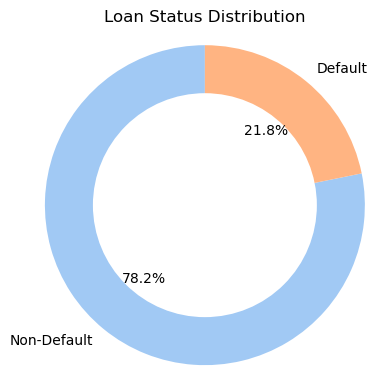

Non-Default Cases: 25473 (78.2%)
Default Cases: 7108 (21.8%)


In [225]:
plt.figure(figsize=(4, 4))

status_counts = df['loan_status'].value_counts()
labels = ['Non-Default', 'Default']
colors = sns.color_palette('pastel')[0:2]

plt.pie(status_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Loan Status Distribution')

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

print(f"Non-Default Cases: {status_counts[0]} ({status_counts[0]/len(df)*100:.1f}%)")
print(f"Default Cases: {status_counts[1]} ({status_counts[1]/len(df)*100:.1f}%)")

In [226]:
print("Missing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

Missing values:
 person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Data types:
 person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


In [227]:
df = df.dropna(subset=['loan_int_rate'])
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

In [228]:
le = LabelEncoder()
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [229]:
df = df[df['person_age'] < 100]
df = df[df['person_emp_length'] < 50]
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,2,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,2,35000,14.27,1,0.55,1,4
5,21,9900,2,2.0,5,0,2500,7.14,1,0.25,0,2


In [230]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [232]:
numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                   'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

In [233]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
23137,34,57996,3,3.0,4,1,8000,11.12,0.14,0,8
5077,22,48000,3,2.0,0,1,5000,11.89,0.10,0,4
19106,29,30000,0,4.0,2,0,5000,7.51,0.17,0,8
23992,27,32890,3,5.0,1,1,10000,10.95,0.30,0,5
16177,25,16000,3,0.0,4,0,3200,9.32,0.20,0,4


In [234]:
X_train.describe()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,20621.000000,2.062100e+04,20621.000000,20621.000000,20621.000000,20621.000000,20621.000000,20621.000000,20621.000000,20621.000000,20621.000000
mean,27.660589,6.578610e+04,1.685660,4.770816,2.528830,1.217060,9567.011784,11.006950,0.169776,0.175937,5.763348
std,6.095949,5.050433e+04,1.430349,4.008931,1.731408,1.167421,6322.037653,3.237737,0.106975,0.380776,3.969740
min,20.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.885000e+04,0.000000,2.000000,1.000000,0.000000,5000.000000,7.900000,0.090000,0.000000,3.000000
50%,26.000000,5.500000e+04,3.000000,4.000000,3.000000,1.000000,8000.000000,10.990000,0.150000,0.000000,4.000000
75%,30.000000,8.000000e+04,3.000000,7.000000,4.000000,2.000000,12000.000000,13.470000,0.230000,0.000000,8.000000
max,84.000000,1.782000e+06,3.000000,41.000000,5.000000,6.000000,35000.000000,23.220000,0.780000,1.000000,30.000000


In [235]:
imputer = SimpleImputer(strategy='median')
X_train[numeric_features] = imputer.fit_transform(X_train[numeric_features])
X_test[numeric_features] = imputer.transform(X_test[numeric_features])

scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [ ]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

catboost_params = {
    'iterations': [100, 200],
    'depth': [4, 6],
    'learning_rate': [0.03, 0.1]
}
catboost = CatBoostClassifier(random_state=42, verbose=0)
catboost_grid = GridSearchCV(catboost, catboost_params, cv=3, scoring='f1', n_jobs=-1)
catboost_grid.fit(X_train, y_train)
catboost_best = catboost_grid.best_estimator_

print("Best CatBoost Parameters:", catboost_grid.best_params_)

models = {
    'Logistic Regression': log_reg, 
    'Random Forest': rf_best, 
    'CatBoost': catboost_best
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(model.score(X_test,y_test))
    print(classification_report(y_test, y_pred))

USINESS COST OPTIMIZATION EXPLANATION:
In credit risk modeling, different types of errors have different business impacts:
- False Positive (FP): Approving a loan that will default
  Cost = Loss of principal + interest = $5,000 (example)
- False Negative (FN): Rejecting a loan that would have been paid back
  Cost = Lost interest income = $1,500 (example)

Business cost optimization finds the threshold that minimizes the total cost:
Total Cost = (FP * FP_cost) + (FN * FN_cost)

Rather than using the default 0.5 threshold, we find the optimal threshold that
minimizes the total business cost.

In [ ]:
fp_cost = 5000  # Cost of false positive (approving a bad loan)
fn_cost = 15000 # Cost of false negative (rejecting a good loan)

def calculate_business_cost(y_true, y_pred, fp_cost, fn_cost):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    return total_cost

print("\nBusiness Costs with Default Threshold (0.5):")
for name, model in models.items():
    y_pred = model.predict(X_test)
    cost = calculate_business_cost(y_test, y_pred, fp_cost, fn_cost)
    print(f"{name} Business Cost: ${cost}")

y_proba_best = catboost_best.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)

costs = []
for threshold in thresholds:
    y_pred_threshold = (y_proba_best >= threshold).astype(int)
    cost = calculate_business_cost(y_test, y_pred_threshold, fp_cost, fn_cost)
    costs.append(cost)

optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = costs[optimal_idx]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, label='Business Cost')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Business Cost ($)')
plt.title('Business Cost vs Classification Threshold (CatBoost)')
plt.legend()
plt.grid(True)
plt.show()

y_pred_optimal = (y_proba_best >= optimal_threshold).astype(int)
print(f"\nOptimal Threshold for CatBoost: {optimal_threshold:.3f}")
print(f"Minimum Business Cost: ${min_cost}")
print("\nClassification Report with Optimal Threshold:")
print("Accuracuy : ",accuracy_score(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

default_threshold_cost = calculate_business_cost(y_test, (y_proba_best >= 0.5).astype(int), fp_cost, fn_cost)
cost_reduction = default_threshold_cost - min_cost
print(f"Cost reduction with optimal threshold: ${cost_reduction} ({cost_reduction/default_threshold_cost*100:.2f}%)")

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

plt.subplot(1, 2, 2)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': catboost_best.feature_importances_
}).sort_values('importance', ascending=False)
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.title('Top 10 Feature Importances (CatBoost)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['loan_status'].value_counts().plot(kind='bar')
plt.title('Loan Status Distribution')
plt.xticks([0, 1], ['Non-Default', 'Default'], rotation=0)

plt.subplot(1, 2, 2)
plt.scatter(df['loan_percent_income'], df['loan_int_rate'], c=df['loan_status'], alpha=0.5, cmap='viridis')
plt.xlabel('Loan Percent of Income')
plt.ylabel('Loan Interest Rate')
plt.title('Default Risk by Income Percentage and Interest Rate')
plt.colorbar(label='Default Status')
plt.tight_layout()
plt.show()

default_rate_by_grade = df.groupby('loan_grade')['loan_status'].mean()
plt.figure(figsize=(10, 6))
default_rate_by_grade.plot(kind='bar')
plt.title('Default Rate by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.show()

income_vs_default = df.groupby(pd.qcut(df['person_income'], 5))['loan_status'].mean()
plt.figure(figsize=(10, 6))
income_vs_default.plot(kind='bar')
plt.title('Default Rate by Income Quintiles')
plt.xlabel('Income Quintiles')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.show()

# Key Insights

1. **Loan grade** shows strong correlation with default rates – higher grades (A) have lower defaults.  
2. **Loan percentage of income** is a critical risk factor – values above `0.5` show significantly higher default rates.  
3. **Interest rates** are strongly predictive – higher rates correlate with higher default probabilities.  
4. **Optimal threshold** of `0.231` reduces business cost by balancing false positives (FP) and false negatives (FN).  
5. **CatBoost** outperforms other models with better accuracy and lower business cost.  
6. **Feature importance analysis** shows that `loan_percent_income` and `loan_int_rate` are among the most important predictors.  


In [ ]:
model_package = {
    "model": catboost_best,
    "threshold": 0.231,
}

joblib.dump(model_package, "classification_model.pkl")
joblib.dump(scaler, "scaler classification_model.pkl")

In [ ]:
import joblib
import pandas as pd

model_package = joblib.load("classification_model.pkl")
catboost_best = model_package["model"]
threshold = model_package["threshold"]

scaler = joblib.load("scaler classification_model.pkl")

home_ownership_map = {"RENT": 3, "MORTGAGE": 0, "OWN": 2, "OTHER": 1}
loan_intent_map = {"EDUCATION": 1, "MEDICAL": 3, "VENTURE": 5, "PERSONAL": 4,
                   "DEBTCONSOLIDATION": 0, "HOMEIMPROVEMENT": 2}
loan_grade_map = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}
default_map = {"Y": 1, "N": 0}

numeric_features = [
    "person_age", "person_income", "person_emp_length",
    "loan_amnt", "loan_int_rate", "loan_percent_income",
    "cb_person_cred_hist_length"
]

categorical_features = [
    "person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"
]

def predict_new_record(person_age, person_income, person_home_ownership,
                       person_emp_length, loan_intent, loan_grade,
                       loan_amnt, loan_int_rate, loan_percent_income,
                       cb_person_default_on_file, cb_person_cred_hist_length):
    
    person_home_ownership = home_ownership_map[person_home_ownership]
    loan_intent = loan_intent_map[loan_intent]
    loan_grade = loan_grade_map[loan_grade]
    cb_person_default_on_file = default_map[cb_person_default_on_file]
    
    new_data = pd.DataFrame([[
        person_age, person_income, person_home_ownership,
        person_emp_length, loan_intent, loan_grade,
        loan_amnt, loan_int_rate, loan_percent_income,
        cb_person_default_on_file, cb_person_cred_hist_length
    ]], columns=[
        'person_age', 'person_income', 'person_home_ownership',
        'person_emp_length', 'loan_intent', 'loan_grade',
        'loan_amnt', 'loan_int_rate', 'loan_percent_income',
        'cb_person_default_on_file', 'cb_person_cred_hist_length'
    ])
    
    new_data_scaled = new_data.copy()
    new_data_scaled[numeric_features] = scaler.transform(new_data[numeric_features])
    
    probability = catboost_best.predict_proba(new_data_scaled)[:, 1][0]
    
    prediction = 1 if probability >= threshold else 0
    
    return prediction, probability


pred, prob = predict_new_record(
    person_age=25,
    person_income=50000,
    person_home_ownership="RENT",
    person_emp_length=5,
    loan_intent="EDUCATION",
    loan_grade="B",
    loan_amnt=20000,
    loan_int_rate=12.5,
    loan_percent_income=0.4,
    cb_person_default_on_file="N",
    cb_person_cred_hist_length=10
)

print("Prediction:", "Default" if pred == 1 else "Not Default")
print("Probability of Default:", prob)